# Inpainting Flu Dynamics Forecasts
Based on _The annotated diffusion model_ from Niels Rogge and Kashif Rasul at Hugging Face. More information and annotations are found on `dev/HF-annotated-diffusion-ref.ipynb`

In [1]:
# Download if from google collab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if IN_COLAB:
    # Create the directory structure and install the packages to run in collab
    !pip install einops epiweeks
    # !mkdir -p datasets/Flusight-forecast-data/data-locations
    # !mkdir -p helpers
    # !mkdir datasets/Flusight-forecast-data/data-truth/
    # !mkdir -p datasets/synthetic/
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/inpainting-idforecasts-stripped
!ls

FluSight Retrospective plots dev
README.md                    fig_diffusion.png
West-Nile Virus              helpers
__pycache__                  inpaintingFluForecasts.ipynb
checkpoint-199.pth           memories
checkpoint-699.pth           outreach
data_classes.py              referenceimplementations
data_utils.py                results
datasets                     runjupyter.sh
datasets_builder.ipynb       update-data.sh


In [3]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

import numpy as np
import pandas as pd
import xarray as xr

import data_utils, data_classes
from torch.utils.data import DataLoader
from torchvision import transforms
import datetime

flusetup = data_utils.FluSetup.from_flusight(fluseason_startdate=pd.to_datetime("2020-12-15"))
flusetup = data_utils.FluSetup.from_flusight(fluseason_startdate=pd.to_datetime("2022-07-24"), remove_territories=True)

image_size = 64
channels = 1
batch_size = 512 * max(1,torch.cuda.device_count())

/Users/chadi/opt/miniconda3/envs/diffusion_torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Spatial Setup with 53 locations.
Spatial Setup with 51 locations.


## Prepare ground-truth for inpainting

In [4]:
# if True, take a training data sample as gt:
if False: 
    inpaintfrom_idx = 19
    gt_keep_mask = np.ones((channels,image_size,image_size))
    gt_keep_mask[:,inpaintfrom_idx:,:] = 0
    # mask is ones for the known pixels, and zero for the ones to be infered
    gt = data.getitem_nocast(4)
    print(gt.shape)
    show_tensor_image(gt, place=ipl)
    plt.show()

In [5]:
#flusetup = data_utils.FluSetup.from_flusight(fluseason_startdate=pd.to_datetime("2020-12-15"))
flusight = data_utils.get_from_epidata(dataset="flusight", flusetup=flusetup, write=False)

⚠️ ⚠️ ⚠️ Make sure ./update_data.sh is ran AND that the fork is updated


In [6]:
gt_df = flusight.copy()
gt_df = gt_df[gt_df["fluseason"] == 2022]
gt_df = gt_df[gt_df["location_code"].isin(flusetup.locations)]

In [7]:
flusight

,location,location_name_x,value,week_enddate,abbreviation,location_name_y,population,count_rate1per100k,count_rate2per100k,geoid,location_code,fluseason,fluseason_fraction
0,01,Alabama,0,2020-01-11,AL,Alabama,5039877.0,50.0,101.0,01000,01,2019,0.468493
1,15,Hawaii,0,2020-01-11,HI,Hawaii,1441553.0,14.0,29.0,15000,15,2019,0.468493
2,18,Indiana,0,2020-01-11,IN,Indiana,6805985.0,68.0,136.0,18000,18,2019,0.468493
3,27,Minnesota,0,2020-01-11,MN,Minnesota,5707390.0,57.0,114.0,27000,27,2019,0.468493
4,30,Montana,0,2020-01-11,MT,Montana,1104271.0,11.0,22.0,30000,30,2019,0.468493
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8493,50,Vermont,1,2023-03-04,VT,Vermont,645570.0,6.0,13.0,50000,50,2022,0.610959
8494,53,Washington,57,2023-03-04,WA,Washington,7738692.0,77.0,155.0,53000,53,2022,0.610959
8495,55,Wisconsin,3,2023-03-04,WI,Wisconsin,5895908.0,59.0,118.0,55000,55,2022,0.610959
8496,54,West Virginia,8,2023-03-04,WV,West Virginia,1782959.0,18.0,36.0,54000,54,2022,0.610959


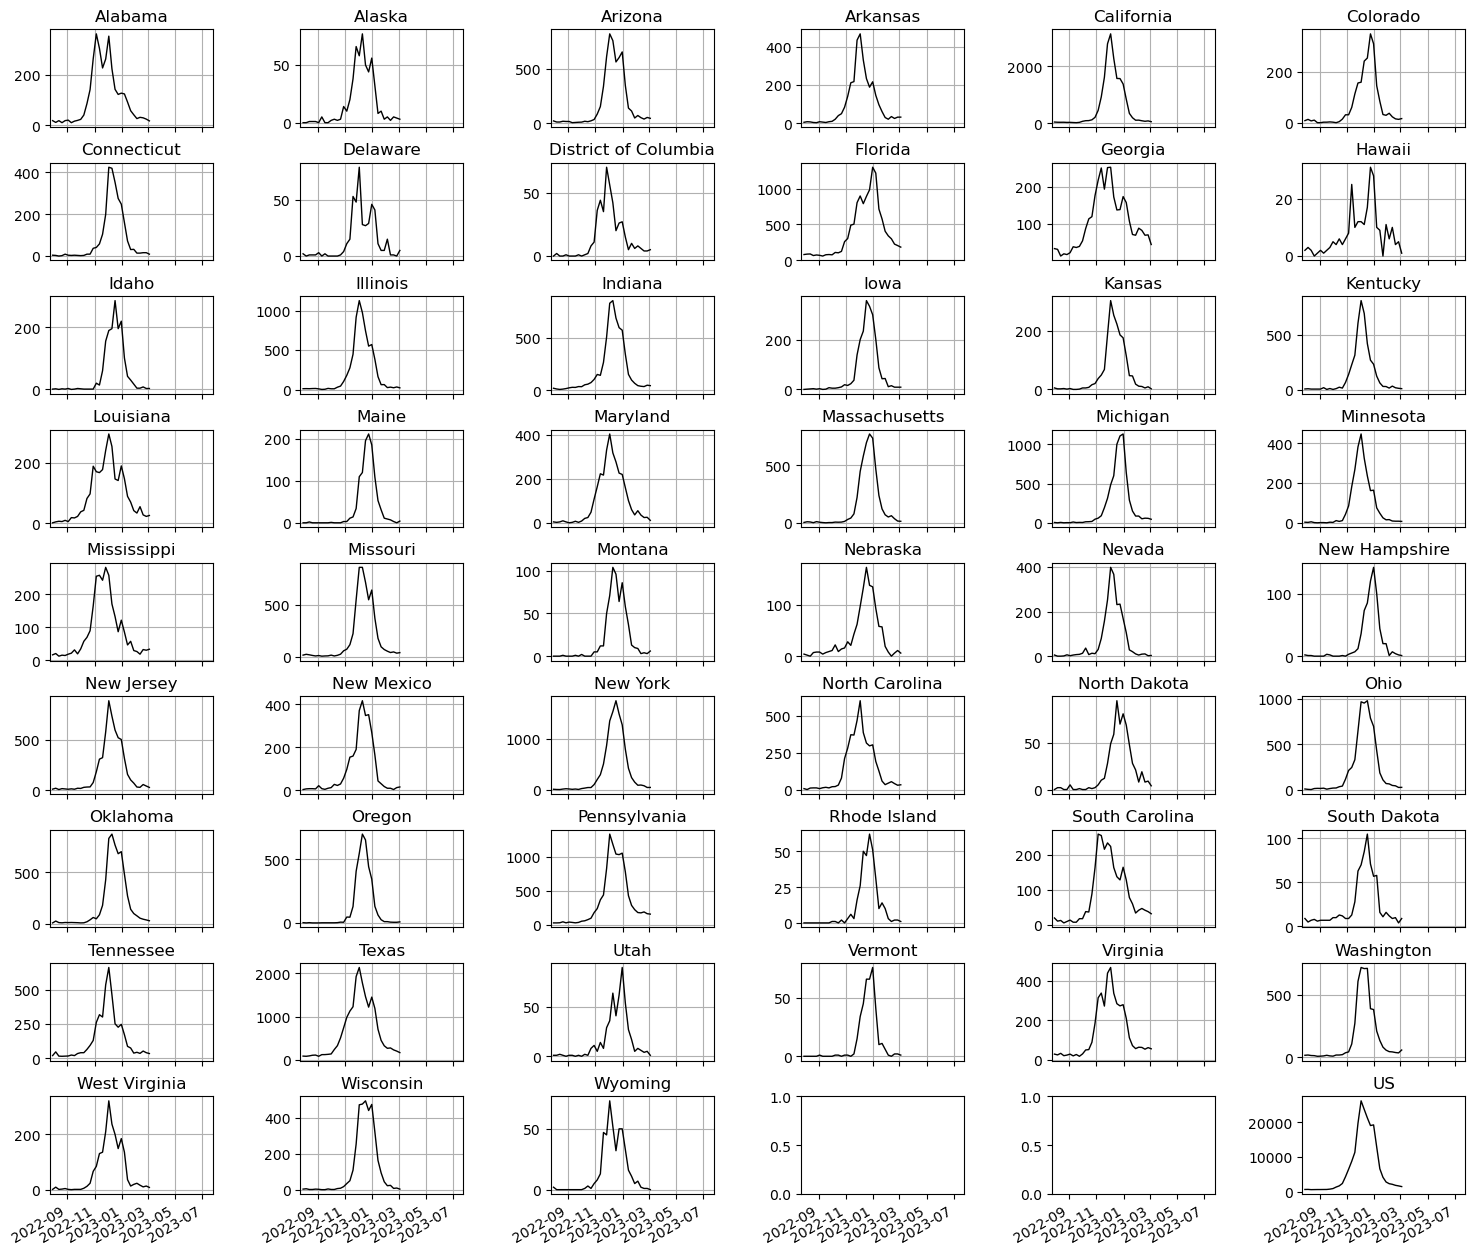

In [8]:
fig, axes = plt.subplots(9, 6, sharex=True, figsize=(15,15))
gt_piv  = gt_df.pivot(index = "week_enddate", columns='location_code', values='value')
for idx, pl in enumerate(gt_piv.columns):
    ax = axes.flat[idx]
    ax.plot(gt_piv[pl], lw=1, color='k')
    ax.set_title(flusetup.get_location_name(pl))
    ax.grid()
    ax.set_xlim(flusetup.fluseason_startdate, flusetup.fluseason_startdate + datetime.timedelta(days=365))
    #ax.set_xticks(flusetup.get_dates(52).resample("M"))
    #ax.plot(pd.date_range(flusetup.fluseason_startdate, flusetup.fluseason_startdate + datetime.timedelta(days=64*7), freq="W-SAT"), data.flu_dyn[-50:,0,:,idx].T, c='r', lw=.5, alpha=.2)

ax = axes.flat[-1]
ax.plot(gt_piv[flusetup.locations].sum(axis=1), color="black", linewidth=1)
ax.set_title("US")
fig.tight_layout()
fig.autofmt_xdate()

In [9]:
gt_xarr = data_utils.dataframe_to_xarray(gt_df, flusetup=flusetup, 
            xarray_name = "gt_flusight_incidHosp", 
            xarrax_features = "incidHosp")
print(gt_xarr.shape)

(1, 64, 64)


In [10]:
inpaintfrom_idx = len(gt_df.week_enddate.unique())
print(f"{inpaintfrom_idx} weeks already in data, inpainting the next ones")

32 weeks already in data, inpainting the next ones


In [11]:
gt_df.week_enddate.unique()

array(['2022-07-30T00:00:00.000000000', '2022-08-06T00:00:00.000000000',
       '2022-08-13T00:00:00.000000000', '2022-08-20T00:00:00.000000000',
       '2022-08-27T00:00:00.000000000', '2022-09-03T00:00:00.000000000',
       '2022-09-10T00:00:00.000000000', '2022-09-17T00:00:00.000000000',
       '2022-09-24T00:00:00.000000000', '2022-10-01T00:00:00.000000000',
       '2022-10-08T00:00:00.000000000', '2022-10-15T00:00:00.000000000',
       '2022-10-22T00:00:00.000000000', '2022-10-29T00:00:00.000000000',
       '2022-11-05T00:00:00.000000000', '2022-11-12T00:00:00.000000000',
       '2022-11-19T00:00:00.000000000', '2022-11-26T00:00:00.000000000',
       '2022-12-03T00:00:00.000000000', '2022-12-10T00:00:00.000000000',
       '2022-12-17T00:00:00.000000000', '2022-12-24T00:00:00.000000000',
       '2022-12-31T00:00:00.000000000', '2023-01-07T00:00:00.000000000',
       '2023-01-14T00:00:00.000000000', '2023-01-21T00:00:00.000000000',
       '2023-01-28T00:00:00.000000000', '2023-02-04

## Define a PyTorch Dataset + DataLoader

In [12]:
data = data_classes.FluDataset.from_fluview(
                                         flusetup=flusetup,
                                         download=False, 
                                         #transform=data_classes.transform_randomscale
                                         )

data = data_classes.FluDataset.from_csp_SMHR1('datasets/synthetic/CSP_FluSMHR1_weekly_padded_4scn.nc', channels=channels)
data.test(6)

created dataset with max [19.4177], full dataset has shape (13, 1, 64, 64)
created dataset with max [14603.53538403], full dataset has shape (1199, 1, 64, 64)
test passed: back and forth transformation are ok ✅


In [13]:
data = data_classes.FluDataset.from_SMHR1_fluview(flusetup=flusetup, download=False)

After repeat, fluview data has shape (1170, 1, 64, 64) vs (1199, 1, 64, 64) from csp
created dataset with max [14603.53538403], full dataset has shape (2369, 1, 64, 64)


In [14]:
data.flu_dyn.shape

(2369, 1, 64, 64)

In [15]:
scaling_per_channel = np.sqrt(max(data.max_per_feature, gt_xarr.max(dim=["date", "place"])).data)
scaling_per_channel

array([120.84508837])

(array([  1.,   0.,   0.,   1.,   1.,   1.,   3.,   7.,   7.,  11.,  12.,
         16.,  25.,  36.,  33.,  51.,  67.,  96., 121., 147., 168., 195.,
        239., 269., 268., 344., 386., 419., 475., 454., 498., 503., 490.,
        508., 453., 442., 430., 410., 400., 328., 312., 272., 199., 170.,
        180., 114., 105.,  62.,  65.,  47.,  38.,  33.,  20.,  19.,  10.,
         15.,  15.,   5.,   3.,   0.,   1.]),
 array([-0.20401868, -0.16687167, -0.12972465, -0.09257763, -0.05543062,
        -0.0182836 ,  0.01886341,  0.05601043,  0.09315745,  0.13030446,
         0.16745148,  0.20459849,  0.24174551,  0.27889253,  0.31603954,
         0.35318656,  0.39033357,  0.42748059,  0.46462761,  0.50177462,
         0.53892164,  0.57606865,  0.61321567,  0.65036269,  0.6875097 ,
         0.72465672,  0.76180373,  0.79895075,  0.83609777,  0.87324478,
         0.9103918 ,  0.94753881,  0.98468583,  1.02183285,  1.05897986,
         1.09612688,  1.13327389,  1.17042091,  1.20756793,  1.24471494,


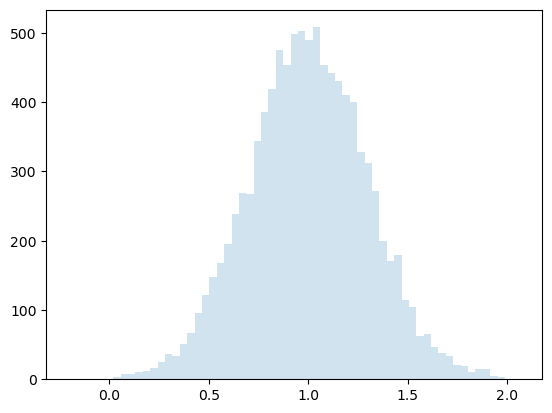

In [16]:
mu = 1
sigma = .3
plt.hist(np.random.normal(mu, sigma, 10000), bins='auto', histtype='stepfilled', alpha=0.2)

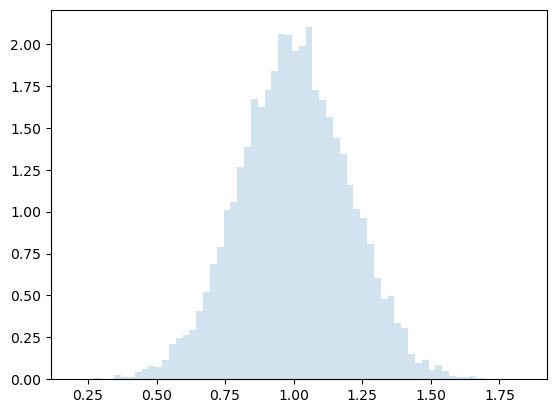

In [17]:
from scipy.stats import skewnorm
r = skewnorm.rvs(loc=1, scale=.2, a=0, size=10000)
r[r<0] = 0
plt.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2);

In [18]:
## define image transformations (e.g. using torchvision)
transform = transforms.Compose([
                    data_classes.transform_sqrt,
                    transforms.Lambda(lambda t: data_classes.transform_channelwisescale(t, scale = 1/scaling_per_channel)),
                    transforms.Lambda(lambda t: data_classes.transform_channelwisescale(t, scale = 2)),
                    #transforms.Lambda(lambda t: data_classes.transform_random_padintime(t, min_shift = -20, max_shift = 20)),
                    #transforms.Lambda(lambda t: data_classes.transform_randomscale(t, min=.1, max=1.9)),
                    #transforms.Lambda(lambda t: data_classes.transform_randomnoise(t, sigma=.3)),
                    #transforms.Lambda(lambda t: data_classes.transform_skewednoise(t, scale=.4, a=-1.8))
                    #transforms.Lambda(lambda t: data_classes.transform_skewednoise(t, scale=.15, a=0))
        ])

transform_inv = transforms.Compose([
                    data_classes.transform_sqrt_inv,
                    transforms.Lambda(lambda t: data_classes.transform_channelwisescale_inv(t, scale = 1/scaling_per_channel)),
                    transforms.Lambda(lambda t: data_classes.transform_channelwisescale_inv(t, scale = 2)),
        ][::-1])      # important reverse the sequence

In [19]:
data.add_transform(transform=transform, transform_inv=transform_inv, bypass_test=True)

In [20]:
sample = data[6]
print(f"There are {len(data)} samples in the dataset, and a single sample has shape {sample.shape}")

There are 2369 samples in the dataset, and a single sample has shape torch.Size([1, 64, 64])


In [21]:
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True) # Dataset is shuffled, but the last incompleted batch is dropped
batch = next(iter(dataloader))
print(f"batch shape {batch.shape}")

batch shape torch.Size([512, 1, 64, 64])


Next, we define a function which we'll apply on-the-fly on the entire dataset. We use the `with_transform` [functionality](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Dataset.with_transform) for that. The function just applies some basic image preprocessing: random horizontal flips, rescaling and finally make them have values in the $[-1,1]$ range.

(array([3321.,  370.,  190.,  112.,   49.,   18.,   12.,   10.,    8.,
           6.]),
 array([0.        , 0.14583318, 0.29166635, 0.43749953, 0.58333271,
        0.72916589, 0.87499906, 1.02083224, 1.16666542, 1.3124986 ,
        1.45833177]),
 <BarContainer object of 10 artists>)

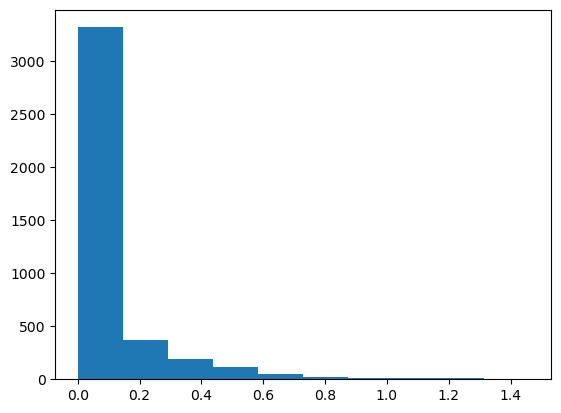

In [22]:
plt.hist(data.getitem_nocast(4).flatten())

In [23]:
batch.shape

torch.Size([512, 1, 64, 64])

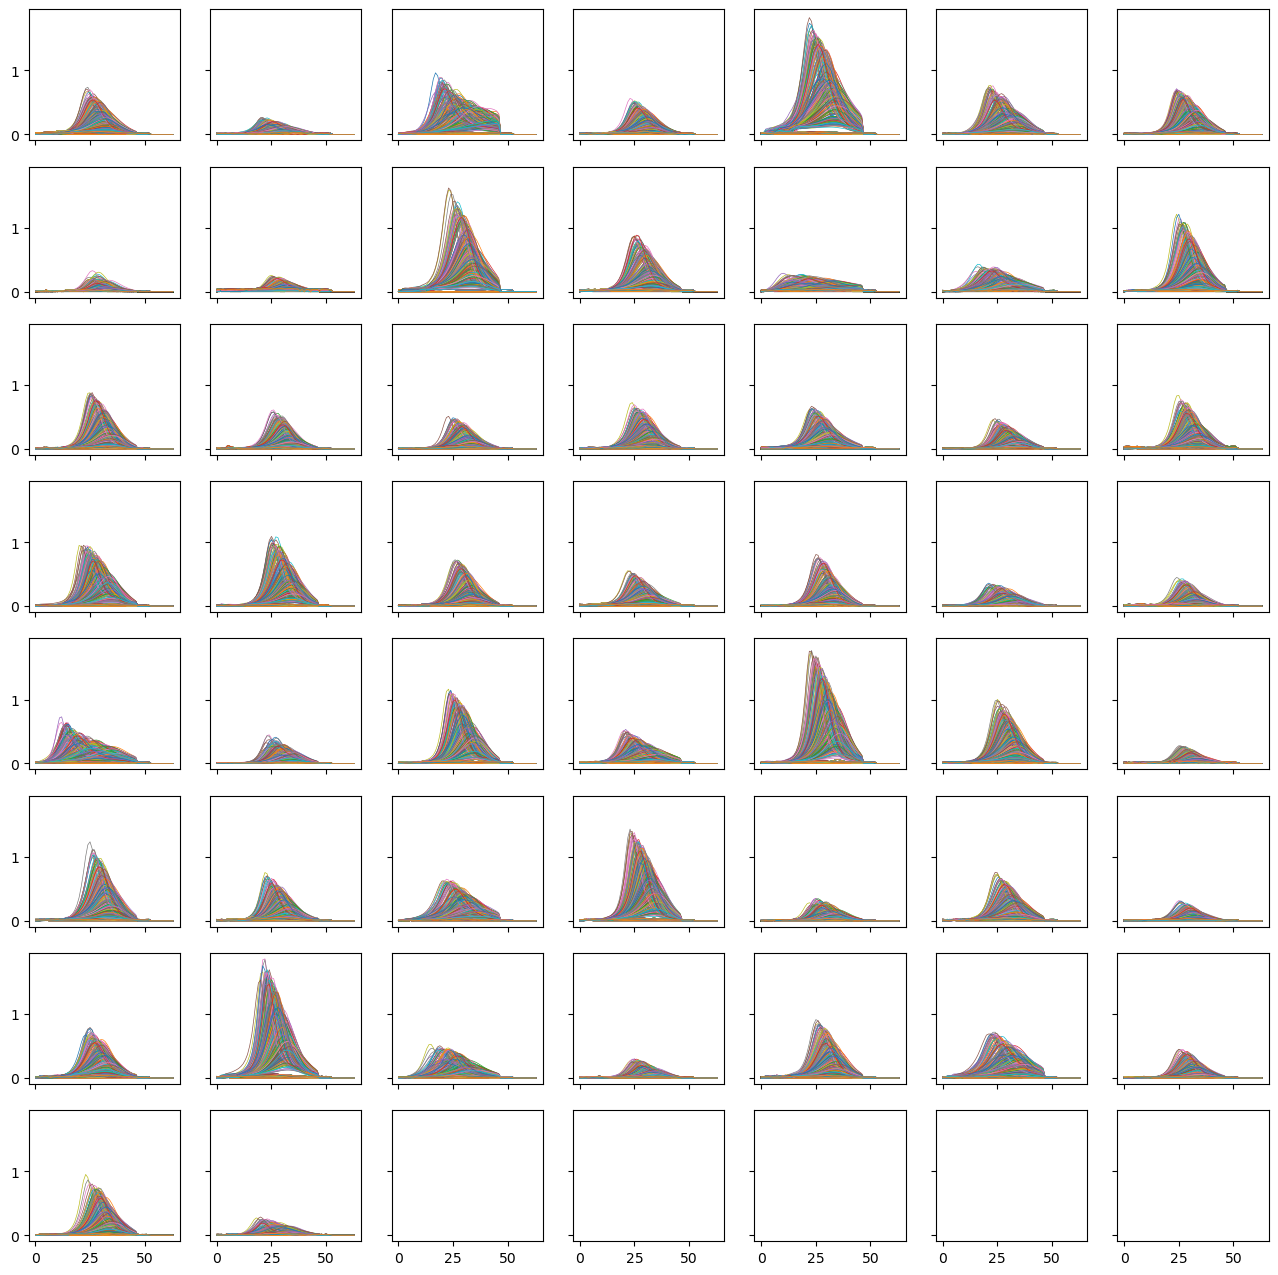

In [24]:
fig, axes = plt.subplots(8, 7, figsize=(16,16), dpi=100, sharex=True, sharey=True)
for ipl in range(51):
    ax = axes.flat[ipl]
    for i in range(batch_size):
        ax.plot(batch[i][0][:,ipl], lw=0.5)

## The neural network
### Network helpers
First, we define some helper functions and classes which will be used when implementing the neural network. Importantly, we define a `Residual` module, which simply adds the input to the output of a particular function (in other words, adds a residual connection to a particular function).

We also define aliases for the up- and downsampling operations.

In [25]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

### Position embeddings
The `SinusoidalPositionEmbeddings` module takes a tensor of shape `(batch_size, 1)` as input (i.e. the noise levels of several noisy images in a batch), and turns this into a tensor of shape `(batch_size, dim)`, with `dim` being the dimensionality of the position embeddings. This is then added to each residual block, as we will see further.

In [26]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### ResNet/ConvNeXT block

Next, we define the core building block of the U-Net model. The DDPM authors employed a Wide ResNet block ([Zagoruyko et al., 2016](https://arxiv.org/abs/1605.07146)), but Phil Wang decided to also add support for a ConvNeXT block ([Liu et al., 2022](https://arxiv.org/abs/2201.03545)), as the latter has achieved great success in the image domain. One can choose one or another in the final U-Net architecture.

In [27]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

### Attention module

Next, we define the attention module, which the DDPM authors added in between the convolutional blocks. Attention is the building block of the famous Transformer architecture ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)), which has shown great success in various domains of AI, from NLP and vision to [protein folding](https://www.deepmind.com/blog/alphafold-a-solution-to-a-50-year-old-grand-challenge-in-biology). Phil Wang employs 2 variants of attention: one is regular multi-head self-attention (as used in the Transformer), the other one is a [linear attention variant](https://github.com/lucidrains/linear-attention-transformer) ([Shen et al., 2018](https://arxiv.org/abs/1812.01243)), whose time- and memory requirements scale linear in the sequence length, as opposed to quadratic for regular attention.

For an extensive explanation of the attention mechanism, we refer the reader to Jay Allamar's [wonderful blog post](https://jalammar.github.io/illustrated-transformer/).

In [28]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

### Group normalization

The DDPM authors interleave the convolutional/attention layers of the U-Net with group normalization ([Wu et al., 2018](https://arxiv.org/abs/1803.08494)). Below, we define a `PreNorm` class, which will be used to apply groupnorm before the attention layer, as we'll see further. Note that there's been a [debate](https://tnq177.github.io/data/transformers_without_tears.pdf) about whether to apply normalization before or after attention in Transformers.

In [29]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### Conditional U-Net

Now that we've defined all building blocks (position embeddings, ResNet/ConvNeXT blocks, attention and group normalization), it's time to define the entire neural network. Recall that the job of the network \\(\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)\\) is to take in a batch of noisy images + noise levels, and output the noise added to the input. More formally:

- the network takes a batch of noisy images of shape `(batch_size, num_channels, height, width)` and a batch of noise levels of shape `(batch_size, 1)` as input, and returns a tensor of shape `(batch_size, num_channels, height, width)`

The network is built up as follows:
* first, a convolutional layer is applied on the batch of noisy images, and position embeddings are computed for the noise levels
* next, a sequence of downsampling stages are applied. Each downsampling stage consists of 2 ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + a downsample operation
* at the middle of the network, again ResNet or ConvNeXT blocks are applied, interleaved with attention
* next, a sequence of upsampling stages are applied. Each upsampling stage consists of 2 ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + an upsample operation
* finally, a ResNet/ConvNeXT block followed by a convolutional layer is applied.

Ultimately, neural networks stack up layers as if they were lego blocks (but it's important to [understand how they work](http://karpathy.github.io/2019/04/25/recipe/)).


In [30]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

## Defining the forward diffusion process

The forward diffusion process gradually adds noise to an image from the real distribution, in a number of time steps $T$. This happens according to a **variance schedule**. The original DDPM authors employed a linear schedule:

> We set the forward process variances to constants
increasing linearly from $\beta_1 = 10^{−4}$
to $\beta_T = 0.02$.

However, it was shown in ([Nichol et al., 2021](https://arxiv.org/abs/2102.09672)) that better results can be achieved when employing a cosine schedule. 

Below, we define various schedules for the $T$ timesteps, as well as corresponding variables which we'll need, such as cumulative variances.

In [31]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    # beta_start = 0.00001
    # beta_end = 0.001
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

To start with, let's use the linear schedule for \\(T=200\\) time steps and define the various variables from the \\(\beta_t\\) which we will need, such as the cumulative product of the variances \\(\bar{\alpha}_t\\). Each of the variables below are just 1-dimensional tensors, storing values from \\(t\\) to \\(T\\). Importantly, we also define an `extract` function, which will allow us to extract the appropriate \\(t\\) index for a batch of indices.


In [32]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)
#betas = quadratic_beta_schedule(timesteps=timesteps)
#betas = sigmoid_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

## Forward diffusion sample

In [33]:
x_start = next(iter(dataloader))
print(f"batch shape {batch.shape}")

batch shape torch.Size([512, 1, 64, 64])


In [34]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

California


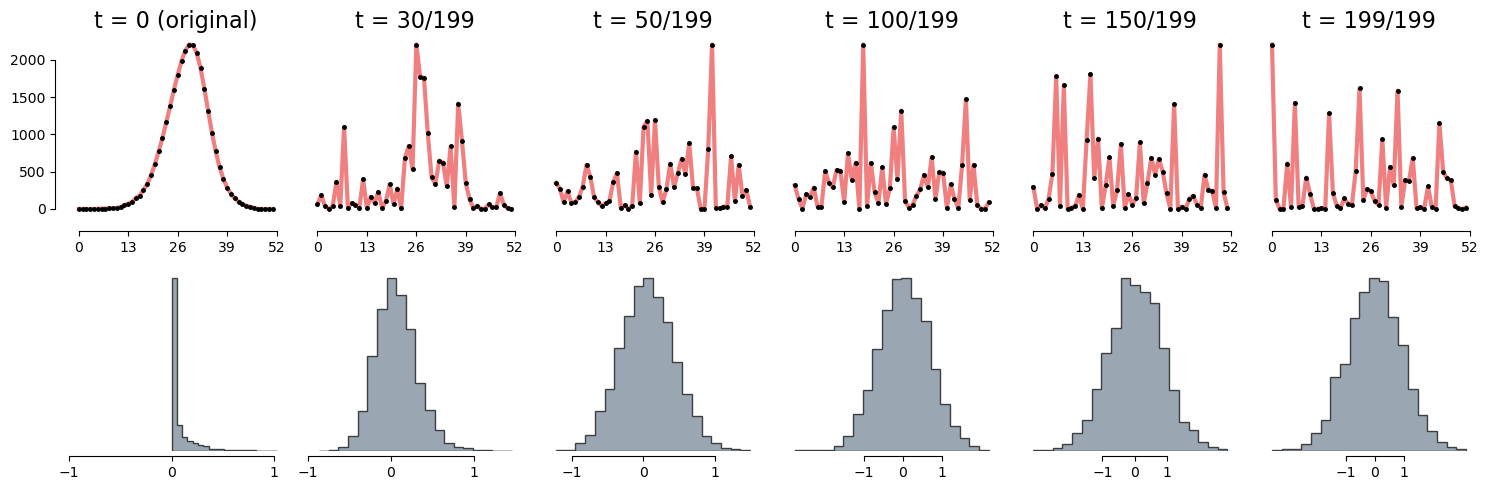

In [35]:
# use seed for reproducability
torch.manual_seed(0)

def plot(imgs, row_title=None, col_title=None, with_histogram=True, plot_size=2, **imshow_kwargs): # with_orig=False,
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    
    mult_rows=1
    if with_histogram:
        mult_rows=2

    place = 4
    color="lightcoral"#'slategray'
    print(flusetup.get_location_name(flusetup.locations[place]))
    
    num_rows = len(imgs)*mult_rows
    num_cols = len(imgs[0]) #+ with_orig
    fig, axs = plt.subplots(figsize=(plot_size*num_cols,plot_size*num_rows), nrows=num_rows, ncols=num_cols, squeeze=False, dpi=100)
    for row_idx, row in enumerate(imgs):
        # row = [transform_inv(a[place,:])] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx*mult_rows, col_idx]
            ax.plot(np.arange(52), transform_inv(np.asarray(img))[0,:52,place], **imshow_kwargs, color=color, lw=3, marker='.', markersize=5, markerfacecolor='black', markeredgecolor='black')
            ax.set_xticks(np.arange(0,53,13))
            sns.despine(ax = ax,  offset = 10, trim = True)
            if col_idx>0:
                ax.set(yticklabels=[], yticks=[])
                sns.despine(ax = ax,  offset = 10, left=True, trim = True)

            
            #ax.set_ylim(0)
            #ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
            if with_histogram:
                ax = axs[row_idx*mult_rows+1, col_idx]
                ax.hist(np.asarray(img).flatten(), bins=20, color='slategray', alpha=0.7, lw=1, edgecolor='k', histtype='stepfilled')
                ax.set_xticks([-1,0,1])
                ax.set(yticklabels=[], yticks=[])
                sns.despine(ax = ax,  offset = 4, left=True, trim = True)
            

    #if with_orig:
    #    axs[0, 0].set(title='Original')
    #    axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    if col_title is not None:
        for col_idx in range(num_cols):
            axs[0, col_idx].set(title=col_title[col_idx])
            axs[0, col_idx].title.set_size(16)

    plt.tight_layout()

#diffused_curves = [[q_sample(x_start[7,:], torch.tensor([t])) for t in [0, 50, 100, 150, 199]] ,
#                   [q_sample(x_start[9,:], torch.tensor([t])) for t in [0, 50, 100, 150, 199]]]#
#plot(diffused_curves, with_histogram=True)

def plot_foward_diffusion(x_start, ts, with_histogram=True, plot_size=2, **imshow_kwargs):
    if not isinstance(x_start, list):
        # Make a 2d grid even if there's just 1 row
        x_start = [x_start]
    diffused_curves = [[x] + [q_sample(x, torch.tensor([t])) for t in ts] for x in x_start]
    col_title = ['t = 0 (original)'] + [f't = {t}/{timesteps-1}' for t in ts]

    plot(diffused_curves, with_histogram=with_histogram, plot_size=plot_size, col_title=col_title, **imshow_kwargs)


plot_foward_diffusion([x_start[500,:]], ts=[30, 50, 100, 150, 199], with_histogram=True, plot_size= 2.5)



This means that we can now define the loss function given the model as follows:

In [36]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise) # forward diffusion of the dataset image
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [37]:
def cuda_mem_info():
    # print(torch.cuda.memory_summary(device=None, abbreviated=False)) is the long form
    convert_to_gb = 1024**3
    return f"{torch.cuda.get_device_name(0)} -- Allocated: {torch.cuda.memory_allocated(0)/convert_to_gb:.1f}GB, Cached: {torch.cuda.memory_reserved(0)/convert_to_gb:.1f}GB -- {torch.cuda.mem_get_info()[0]/convert_to_gb:.1f}/{torch.cuda.mem_get_info()[1]/convert_to_gb:.1f} (free/total)"

The `denoise_model` will be our U-Net defined above. We'll employ the Huber loss between the true and the predicted noise.

## Sampling

In [38]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

## Train the model


In [39]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [ ]:
fit = False

In [ ]:
from torchvision.utils import save_image

from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    use_convnext=False
)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
if device == "cuda":
    print(cuda_mem_info())

# scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

losses = []
epochs = 200

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      #batch_size = batch["pixel_values"].shape[0]
      #batch = batch["pixel_values"].to(device)
      batch_size = batch.shape[0]
      batch = batch.to(device)
      

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      # Important to have a number of epoch sufficiently large to see all the timesteps
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(denoise_model=model, x_start=batch, t=t,  loss_type="huber") #loss_type="l2")#

      if step % 100 == 0:
        print(f"Epoch: {epoch:<4} -- Loss: {loss.item()}")
        if device == "cuda":
          print(f"   -- {cuda_mem_info()}")
      loss.backward()
      optimizer.step()

      if epoch %50 == 0:
        fig, axes = plt.subplots(1, 3, figsize=(4,2), dpi=100)
        axes.flat[0].plot(np.arange(len(losses)), np.array(losses))
        axes.flat[1].plot(np.arange(len(losses[-100:])), np.array(losses[-100:]))
        axes.flat[2].plot(np.arange(len(losses[-50:])), np.array(losses[-50:]))

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

    #scheduler1.step()


```python
save_path = f"{results_folder}/checkpoint-{epoch}.pth")
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, save_path)


model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    use_convnext=False
)
optimizer = Adam(model.parameters(), lr=1e-3)

checkpoint = torch.load(save_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

model.train()
```

In [109]:
save_path = f"checkpoint-{epoch}.pth"
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, save_path)


In [42]:
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    use_convnext=False
)

from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-3)

checkpoint = torch.load("checkpoint-199.pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()

model.train()

Unet(
  (init_conv): Conv2d(1, 42, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=64, out_features=256, bias=True)
    (2): GELU(approximate=none)
    (3): Linear(in_features=256, out_features=256, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0): ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=256, out_features=64, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(42, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 64, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Conv2d(42, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): Re

## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


In [43]:
if device == "cuda":
    print(cuda_mem_info())
    torch.cuda.empty_cache() # make sure we don't keep old stuff
    print(cuda_mem_info())

NameError: name 'device' is not defined

In [44]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=batch_size, channels=channels) # coul batch_size be different ?

sampling loop time step:   0%|          | 1/200 [00:36<2:01:49, 36.73s/it]


KeyboardInterrupt: 

In [49]:
# show a random one
random_index = 3
#plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels))

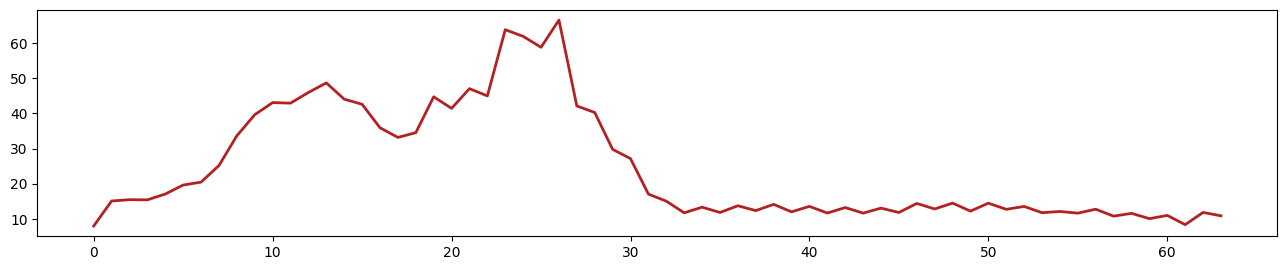

In [50]:
def plot_to_ax(array, ax=None, place=None, multi=False):
    c = ['firebrick', 'slateblue', 'orange']
    # (3, 48, 51)
    if len(array.shape) == 4: # it's a batch
        array = array[0, :, :, :] 
    if ax is None:
        ax = plt.gca() # get current ax
        
    if place is None:
        array_to_plot = array.sum(axis=2)
    else:
        array_to_plot = array[:, :, place]
    for k in range(channels):
        if multi: # several lines will be plotted:
            ax.plot(array_to_plot[k], c = c[k], lw = .5, alpha=.5)
        else:
            ax.plot(array_to_plot[k], c = c[k], lw = 2, alpha=1)
        
def show_tensor_image(image, ax=None, place=None, multi=False):
    plot_to_ax(data.apply_transform_inv(image), ax=ax, place=place, multi=multi)
    
fig, axes = plt.subplots(1, 1, figsize=(16,3), dpi=100)
ax = axes # es.flat[i]
show_tensor_image(samples[-1][random_index], ax = ax)
plt.show()

In [51]:
#till

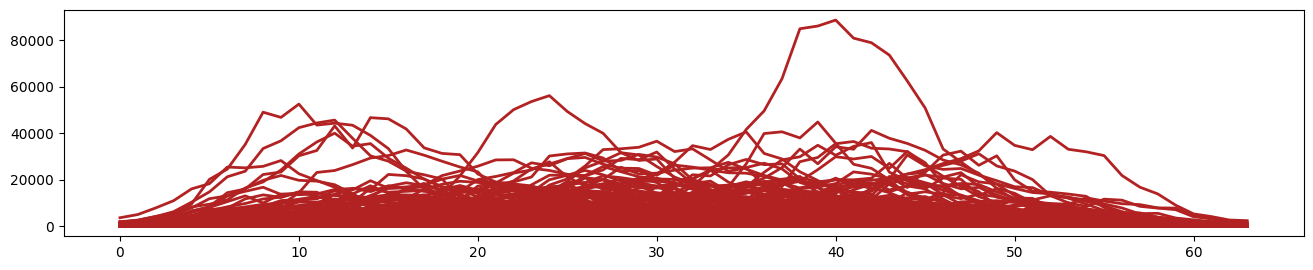

In [52]:
fig, axes = plt.subplots(1, 1, figsize=(16,3), dpi=100)
ax = axes # es.flat[i]
for i in range(batch_size):
    show_tensor_image(samples[-1][i], ax = ax)

#ax.set_ylim(0,10000)

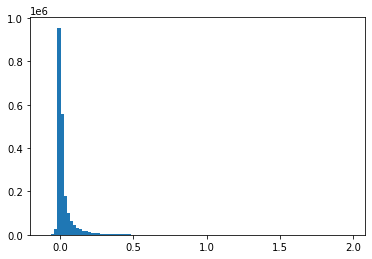

In [53]:
plt.hist(samples[-1].flatten(), bins = 100);

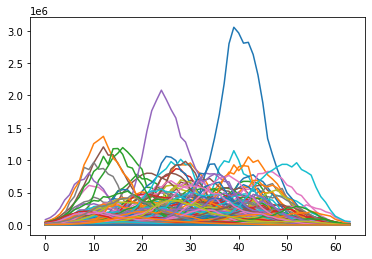

In [54]:
plt.plot(transform_inv(samples[-1][:,0,:,:].sum(axis=2)).T);

(array([280.,  84.,  49.,  23.,  24.,  15.,  10.,   9.,   2.,   7.,   2.,
          4.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([3.06554025e+02, 1.02119814e+05, 2.03933074e+05, 3.05746335e+05,
        4.07559595e+05, 5.09372855e+05, 6.11186115e+05, 7.12999375e+05,
        8.14812635e+05, 9.16625896e+05, 1.01843916e+06, 1.12025242e+06,
        1.22206568e+06, 1.32387894e+06, 1.42569220e+06, 1.52750546e+06,
        1.62931872e+06, 1.73113198e+06, 1.83294524e+06, 1.93475850e+06,
        2.03657176e+06, 2.13838502e+06, 2.24019828e+06, 2.34201154e+06,
        2.44382480e+06, 2.54563806e+06, 2.64745132e+06, 2.74926458e+06,
        2.85107784e+06, 2.95289110e+06, 3.05470436e+06]),
 <BarContainer object of 30 artists>)

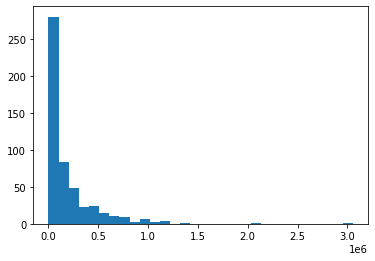

In [55]:
# histogram of peaks. In the US historically it's from 13k to 34k
plt.hist(transform_inv(samples[-1][:,0,:,:].sum(axis=2)).max(axis=1), bins=30)

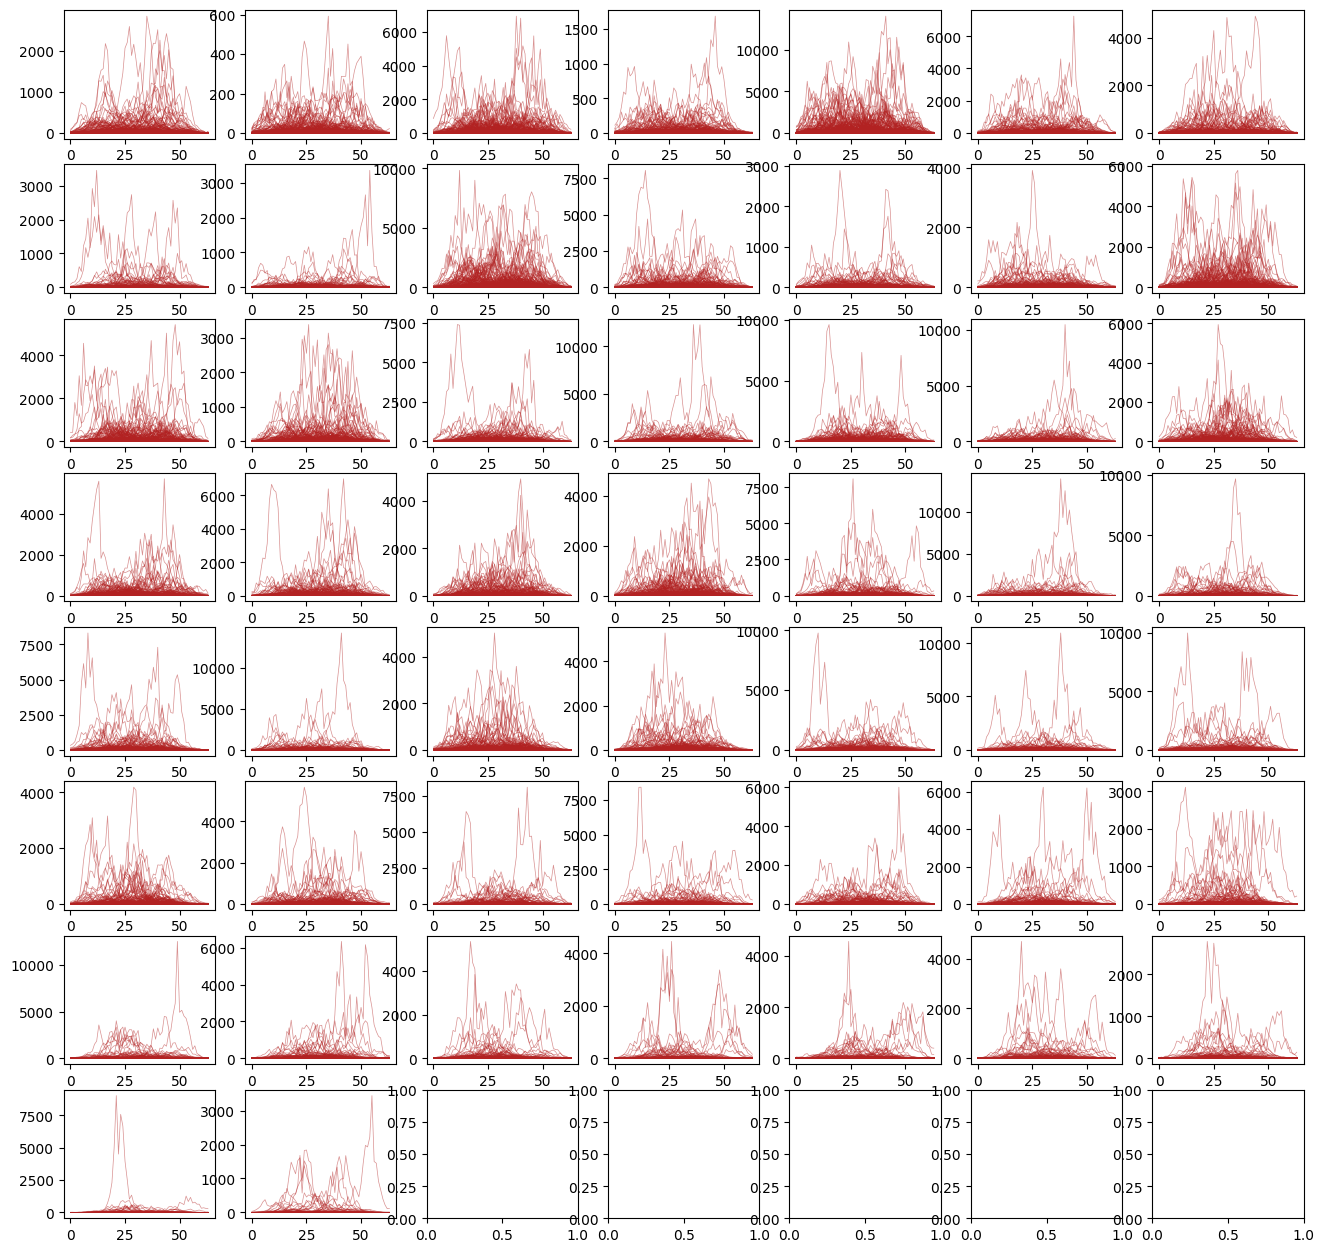

In [56]:
fig, axes = plt.subplots(8, 7, figsize=(16,16), dpi=100)

for ipl in range(51):
    ax = axes.flat[ipl]
    for i in range(batch_size):
        show_tensor_image(samples[-1][i], ax = ax, place=ipl, multi=True)


In [57]:
animate = False
if animate:
    import matplotlib.animation as animation

    random_index = 53
# TODO: the reshape shuffles the information
    fig = plt.figure()
    ims = []
    for i in range(timesteps):
        im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), animated=True)
        ims.append([im])

    animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    animate.save('diffusion.gif')
    plt.show()

In [58]:
if animate:
    plt.ioff()
    for ts in tqdm(range(0, timesteps, 5)):
        fig, axes = plt.subplots(8, 8, figsize=(10,10))
        for ipl in range(51):
            ax = axes.flat[ipl]
            for i in range(0,batch_size, 2):
                show_tensor_image(samples[ts][i], ax = ax, place=ipl)
        plt.savefig(f'results/{ts}.png')
        plt.close(fig)

## Let's add repainting from the RePaint paper

Dimensions are chanel, time, place

In [59]:
transform_notdesc = transforms.Compose([
                    data_classes.transform_sqrt,
                    transforms.Lambda(lambda t: data_classes.transform_channelwisescale(t, scale = 1/scaling_per_channel)),
                    transforms.Lambda(lambda t: data_classes.transform_channelwisescale(t, scale = 2)),
                    #transforms.Lambda(lambda t: data_classes.transform_random_rollintime(t, max_shift = 20)),
        ])

In [60]:
gt = transform_notdesc(gt_xarr.data) # data.apply_transform
print(gt.shape)

(1, 64, 64)


In [61]:
gt_keep_mask = np.ones((channels,image_size,image_size))
gt_keep_mask[:,inpaintfrom_idx:,:] = 0

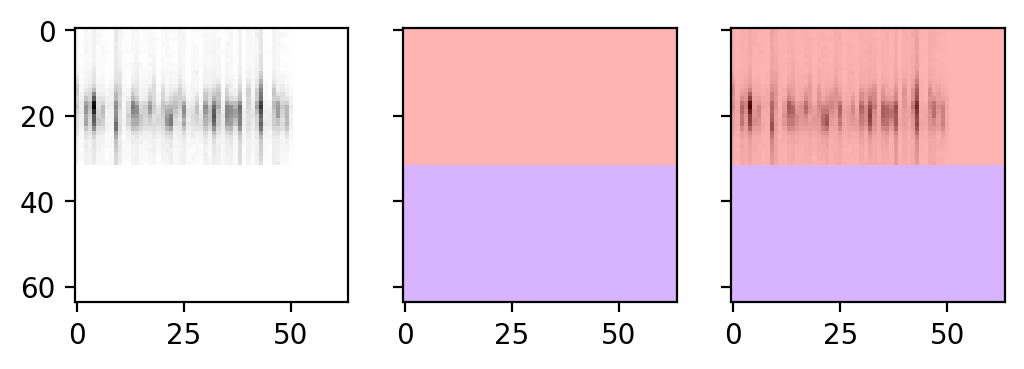

In [62]:
# check that it stitch
fig, axes = plt.subplots(1, 3, figsize=(6,6), dpi=200, sharex=True, sharey=True)
axes[1].imshow(gt_keep_mask[0], alpha=.3, cmap = "rainbow")
axes[0].imshow(gt[0], cmap='Greys')


axes[2].imshow(gt[0], cmap='Greys')
axes[2].imshow(gt_keep_mask[0], alpha=.3, cmap = "rainbow")

In [63]:
device = next(model.parameters()).device
gt_keep_mask = torch.from_numpy(gt_keep_mask).type(torch.FloatTensor).to(device)
gt = torch.from_numpy(gt).type(torch.FloatTensor).to(device)

In [64]:
# schedule with J
t_T = timesteps
jump_len = 5 
jump_n_sample = 5 
jumps = {} 
for j in range(0, t_T - jump_len, jump_len): 
  jumps[j] = jump_n_sample - 1 
t = t_T 
ts = []
while t >= 1: 
  t = t-1
  ts.append(t) 
  if jumps.get(t, 0) > 0: 
   jumps[t] = jumps[t] - 1 
   for _ in range(jump_len): 
     t=t+1 
     ts.append(t)
ts.append(-1)

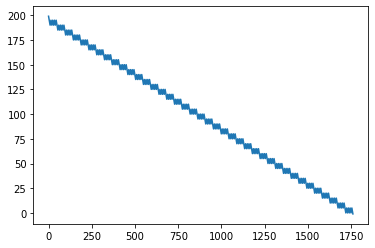

In [65]:
plt.plot(ts)

In [66]:
@torch.no_grad()
def p_sample_paint(model, x, t, t_index):

    # timestep parameters
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    posterior_variance_t = extract(posterior_variance, t, x.shape)

    resampling_steps = 1 # was 50 before
    
    for u in range(resampling_steps):
        # RePaint algorithm, line 4 and 6
        if t_index == 0:
            epsilon = 0
            z = 0
        else:
            epsilon = torch.randn_like(x)
            z = torch.randn_like(x)

        # RePaint algorithm, line 5
        x_tminus1_known = 1/ sqrt_recip_alphas_t * gt + sqrt_one_minus_alphas_cumprod_t**2*epsilon

        # RePaint algorithm, line 4 and 7
        x_tminus1_unknow = sqrt_recip_alphas_t * (
            x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
        ) + torch.sqrt(posterior_variance_t) * z

        x_tminus1 = x_tminus1_known * gt_keep_mask + x_tminus1_unknow * (1 - gt_keep_mask)
        
        
        # TODO This is wrong// used for debug: return the full infered dynamics.
        if t_index == 0:
          x_tminus1 = x_tminus1_unknow
        

        if u < resampling_steps and (t > 1).all():
            # taken from q_sample:
            noise = torch.randn_like(x)
            sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t-1, x.shape)
            sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, 
                            t-1, x.shape)
            x = sqrt_alphas_cumprod_t * x_tminus1 + sqrt_one_minus_alphas_cumprod_t * noise
            
    return x_tminus1

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop_paint(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)   # this is x_T
    imgs = []

    # t_T = timesteps
    # jump_len = 3 
    # jump_n_sample = 3 
    # jumps = {} 
    # for j in range(0, t_T - jump_len, jump_len): 
    #   jumps[j] = jump_n_sample - 1 
    # t = t_T 
    # ts = []
    # while t >= 1: 
    #   t = t-1
    #   ts.append(t) 
    #   if jumps.get(t, 0) > 0: 
    #    jumps[t] = jumps[t] - 1 
    #    for _ in range(jump_len): 
    #       t=t+1 
    #       ts.append(t)
    #ts.append(-1)
    # for i in tqdm(ts, desc='sampling loop time step', total=timesteps):
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample_paint(model = model, 
                             x = img, 
                             t = torch.full((b,), i, device=device, dtype=torch.long), # an array of size "batch_size" containting i
                             t_index = i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample_paint(model, image_size, batch_size=16, channels=3):
    return p_sample_loop_paint(model, shape=(batch_size, channels, image_size, image_size))

In [67]:
if device == "cuda":
    print(cuda_mem_info())
    torch.cuda.empty_cache() # make sure we don't keep old stuff
    print(cuda_mem_info())

In [68]:
timesteps

200

In [69]:
n_samples = 600
all_samples = []
for i in range(max(n_samples//batch_size,1)):
    samples = sample_paint(model, image_size=image_size, batch_size=batch_size, channels=channels) # coul batch_size be different ?
    all_samples.append(samples)

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

In [70]:
samples[0].shape

(512, 1, 64, 64)

In [71]:
fluforecasts = -1*np.ones((batch_size*max(n_samples//batch_size,1), 1, 64, 64))
for i in range(max(n_samples//batch_size,1)):
    fluforecasts[i*batch_size:i*batch_size+batch_size] = all_samples[i][-1]

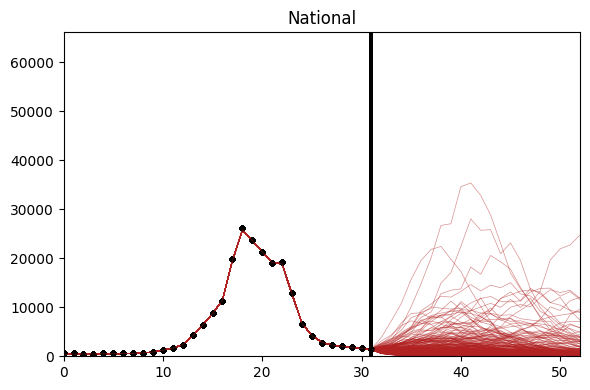

In [72]:
fig, axes = plt.subplots(1, 1, figsize=(6,4), dpi=100, sharex=True)

ax = axes
for i in range(batch_size):
    ax.plot(gt_xarr.data[0,:inpaintfrom_idx].sum(axis=1), color='k', marker='.', ls='')
    show_tensor_image(samples[-1][i], ax = ax, multi=True)
    ax.axvline(inpaintfrom_idx-1, c='k')
    ax.set_xlim(0,52)
    ax.set_ylim(bottom=0, auto=True)
    #ax.grid(visible = True)
    ax.set_title("National")
fig.tight_layout()
plt.show()

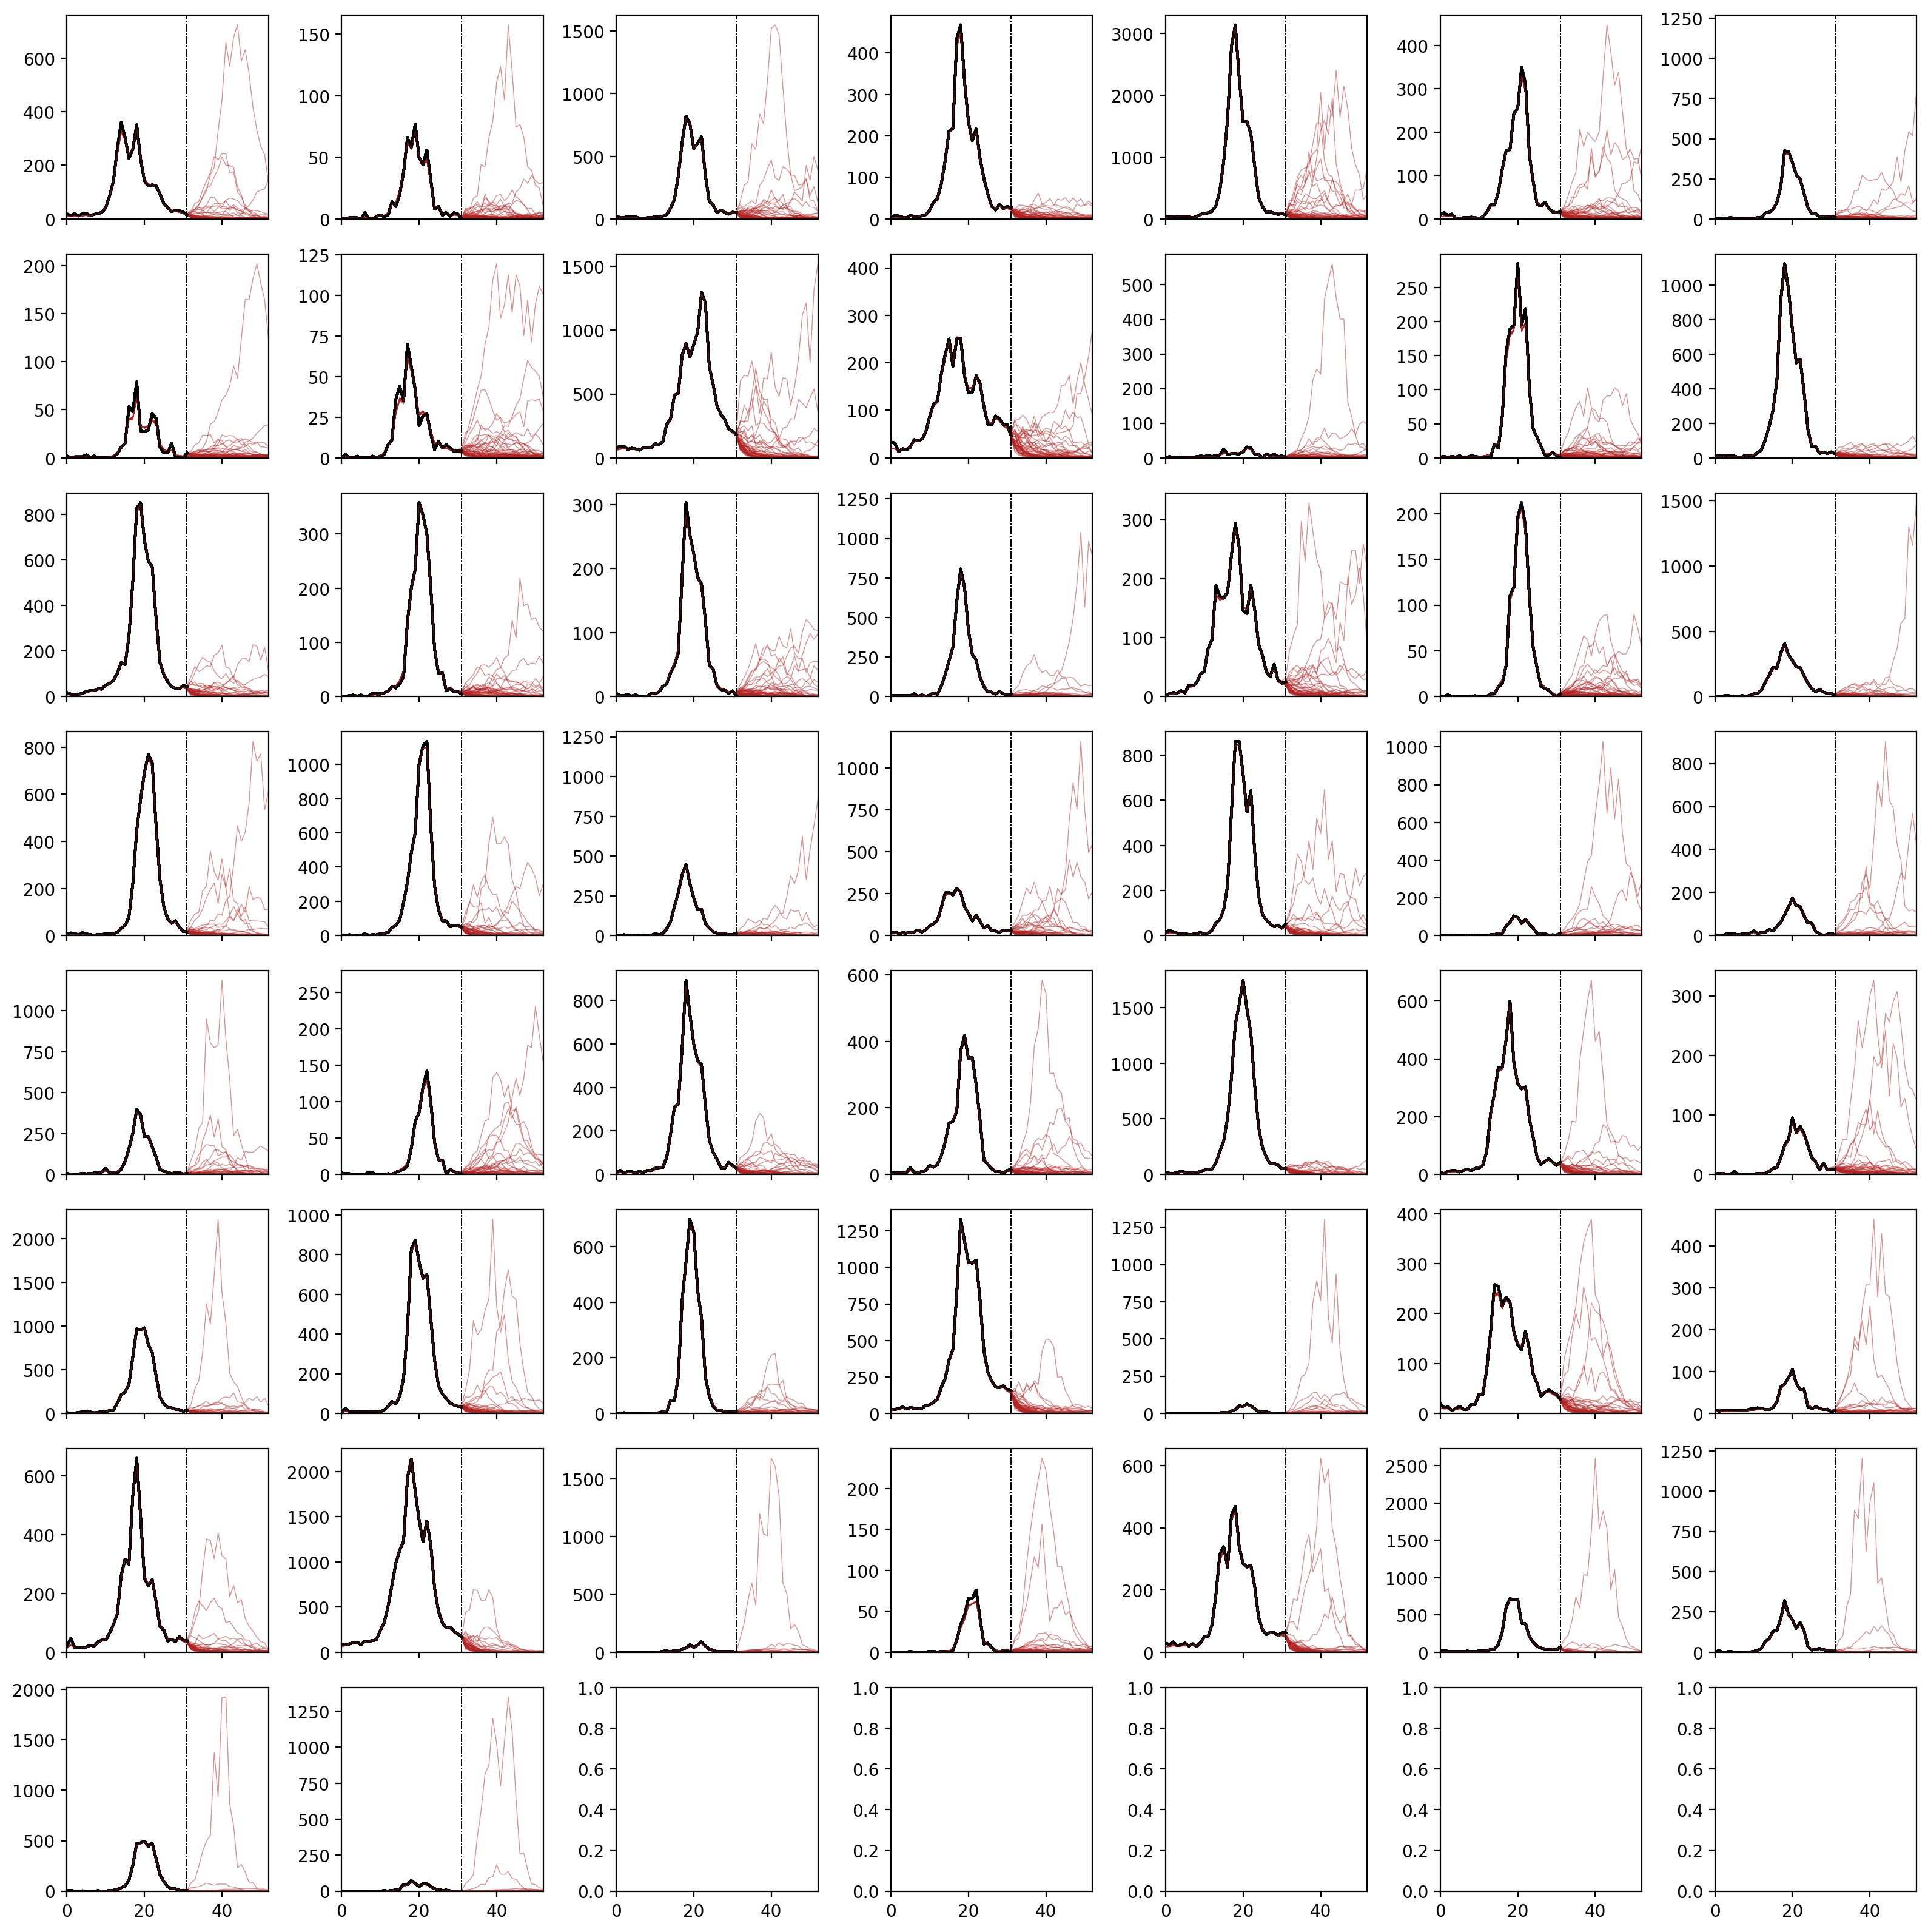

In [73]:
fig, axes = plt.subplots(8, 7, figsize=(16,16), dpi=200, sharex=True)

for ipl in range(51):
    ax = axes.flat[ipl]
    for i in range(min(50, batch_size)):  # print max 50 sims
        ax.plot(gt_xarr.data[0,:inpaintfrom_idx, ipl], color='k')
        show_tensor_image(samples[-1][i], ax = ax, place=ipl, multi=True)
        ax.axvline(inpaintfrom_idx-1, c='k', lw=.7, ls='-.')
        ax.set_xlim(0,52)
        ax.set_ylim(bottom=0, auto=True)
        ax.grid()
        #ax.set_title(get_state_name(places[ipl]))
fig.tight_layout()
#plt.savefig("inpainting.pdf")

In [74]:
flusight_quantiles = np.append(np.append([0.01,0.025],np.arange(0.05,0.95+0.05,0.050)), [0.975,0.99])
fluforecasts.shape

(512, 1, 64, 64)

In [75]:
flusight_quantile_pairs = np.array([flusight_quantiles[:11],flusight_quantiles[12:][::-1]]).T
flusight_quantile_pairs                             

array([[0.01 , 0.99 ],
       [0.025, 0.975],
       [0.05 , 0.95 ],
       [0.1  , 0.9  ],
       [0.15 , 0.85 ],
       [0.2  , 0.8  ],
       [0.25 , 0.75 ],
       [0.3  , 0.7  ],
       [0.35 , 0.65 ],
       [0.4  , 0.6  ],
       [0.45 , 0.55 ]])

In [76]:
fluforecasts_ti = data.apply_transform_inv(fluforecasts)

0.01 0.99
0.025 0.975
0.05 0.9500000000000001
0.1 0.9000000000000001
0.15000000000000002 0.8500000000000001
0.2 0.8
0.25 0.7500000000000001
0.3 0.7000000000000001
0.35000000000000003 0.6500000000000001
0.4 0.6000000000000001
0.45 0.55


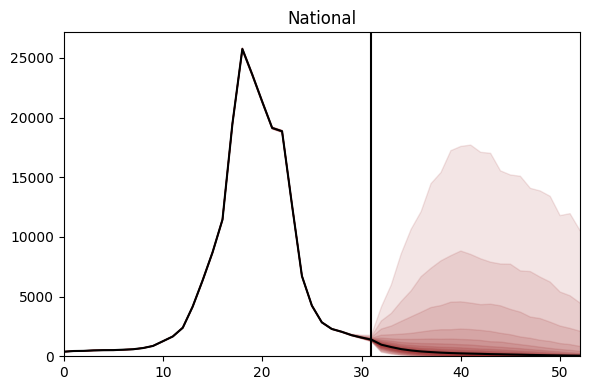

In [77]:
fig, axes = plt.subplots(1, 1, figsize=(6,4), dpi=100, sharex=True)

ax = axes
for iqt in range(11):
    print(flusight_quantile_pairs[iqt,0], flusight_quantile_pairs[iqt,1])
    ax.fill_between(np.arange(64), 
                    np.quantile(fluforecasts_ti, flusight_quantile_pairs[iqt,0], axis=0)[0].sum(axis=1), 
                    np.quantile(fluforecasts_ti, flusight_quantile_pairs[iqt,1], axis=0)[0].sum(axis=1), alpha=.1, color='darkred')
    
ax.plot(np.arange(64), 
        np.quantile(fluforecasts_ti, flusight_quantiles[12], axis=0)[0].sum(axis=1), color='k')
ax.axvline(inpaintfrom_idx-1, c='k')
ax.set_xlim(0,52)
ax.set_ylim(bottom=0, auto=True)
#ax.grid(visible = True)
ax.set_title("National")
fig.tight_layout()
plt.show()

In [78]:
forecast_date = datetime.date(2023,3,6)
forecast_date_str=str(forecast_date)
team_abbrv = "UNC_IDD-InfluPaint"

In [79]:
gt_xarr.data[0,:inpaintfrom_idx].shape

(32, 64)

In [94]:
idx_now = inpaintfrom_idx-1
idx_horizon = idx_now+4

plot_specs = {"all" : {
                      "quantiles_idx":range(11),
                      "color":"darkred"
                      },
              "50-95" : {
                      "quantiles_idx":[1, 6],
                      "color":"darkblue"
                        }
              }

color_gt = "black"

for plot_title, plot_spec in plot_specs.items():
  print(f"doing {plot_title}...")
  fig, axes = plt.subplots(52, 2, figsize=(8,100), dpi=200)
  
  for iax in range(2):
    ax = axes[0][iax]

    x = np.arange(64)
    if iax == 0:
      x_lims = (0, 52)
    elif iax == 1:
      x_lims = (idx_now-3, idx_horizon)

    # US WIDE: quantiles and median, US-wide
    for iqt in plot_spec["quantiles_idx"]:
        print(f"up: {flusight_quantile_pairs[iqt,0]} - lo: {flusight_quantile_pairs[iqt,1]}")
        # TODO: not exactly true that it is the sum of quantiles (sum of quantile is not quantile of sum)
        ylo = np.quantile(fluforecasts_ti, flusight_quantile_pairs[iqt,0], axis=0)[0].sum(axis=1)
        yup = np.quantile(fluforecasts_ti, flusight_quantile_pairs[iqt,1], axis=0)[0].sum(axis=1)
        ax.fill_between(x, 
                        ylo, 
                        yup, 
                        alpha=.1, 
                        color=plot_spec["color"])
        
         # widest quantile pair is the first one. We take the up quantile of it + a few % as x_lim
        if iqt == plot_spec["quantiles_idx"][0]: 
            max_y_value = max(yup[x_lims[0]:x_lims[1]])
            max_y_value = max_y_value + max_y_value*.05 # 10% more

    # median
    ax.plot(x, 
            np.quantile(fluforecasts_ti, flusight_quantiles[12], axis=0)[0].sum(axis=1), color=plot_spec["color"], marker='.')
    # ground truth
    ax.plot(gt_xarr.data[0,:inpaintfrom_idx].sum(axis=1), color=color_gt, marker = '.', lw=.5)
    

    
    ax.set_xlim(x_lims)
    ax.set_ylim(bottom=0, top=max_y_value)
    ax.axvline(idx_now, c='k', lw=.7, ls='-.')
    ax.axvline(idx_horizon, c='k', lw=.7, ls='-.')
    ax.set_title("US")

    # INDIVDIDUAL STATES: quantiles, median and ground-truth
    max_y_value = np.zeros(52)
    for iqt in plot_spec["quantiles_idx"]:
        yup = np.quantile(fluforecasts_ti, flusight_quantile_pairs[iqt,0], axis=0)[0]
        ylo = np.quantile(fluforecasts_ti, flusight_quantile_pairs[iqt,1], axis=0)[0]
        
        # widest quantile pair is the first one. We take the up quantile of it + a few % as x_lim
        if iqt == plot_spec["quantiles_idx"][0]:
          for ipl in range(51):
            max_y_value[ipl] = max(ylo[x_lims[0]:x_lims[1], ipl])
            max_y_value[ipl] = max_y_value[ipl] + max_y_value[ipl]*.05 # 10% more for the y_max value

        for ipl in range(51):
            ax = axes[ipl+1][iax]
            ax.fill_between(x[idx_now:],  yup[idx_now:,ipl], ylo[idx_now:,ipl], alpha=.1, color=plot_spec["color"])
    
    # median line and ground truth for states
    for ipl in range(51):   
        ax = axes[ipl+1][iax]
        # median
        ax.plot(np.arange(64),
                np.quantile(fluforecasts_ti, flusight_quantiles[12], axis=0)[0,:,ipl], color=plot_spec["color"], marker = '.', lw=.5)
        # ground truth
        ax.plot(gt_xarr.data[0,:inpaintfrom_idx, ipl], color=color_gt, marker = '.', lw=.5)

        ax.axvline(idx_now, c='k', lw=.7, ls='-.')
        ax.axvline(idx_horizon, c='k', lw=.7, ls='-.')
        ax.set_xlim(x_lims)
        ax.set_ylim(bottom=0, top=max_y_value[ipl])
        ax.set_title(flusetup.get_location_name(flusetup.locations[ipl]))
  fig.tight_layout()
  plt.savefig(f"{team_abbrv}-{forecast_date_str}-plot{plot_title}.pdf")

if IN_COLAB:
  from google.colab import files
  for qtp_str, qtp_val in plot_specs.items():
    files.download(f"{team_abbrv}-{forecast_date_str}-plot{qtp_str}.pdf")

Output hidden; open in https://colab.research.google.com to view.

In [95]:
## todo: line must be at gt-1

## Data Export

In [96]:
target_dates = pd.date_range(forecast_date, forecast_date + datetime.timedelta(days=4*7), freq="W-SAT")

target_dict= dict(zip(
    target_dates, 
    [f"{n} wk ahead inc flu hosp" for n in range(1,5)]))

print(target_dates)
#pd.DataFrame(colums=["forecast_date","target_end_date","location","type","quantile","value","target"])
df_list=[]
for qt in flusight_quantiles:
    a =  pd.DataFrame(data.apply_transform_inv(np.quantile(fluforecasts[:,:,:,:len(flusetup.locations)], qt, axis=0)[0]), 
              columns= flusetup.locations, index=pd.date_range(flusetup.fluseason_startdate, flusetup.fluseason_startdate + datetime.timedelta(days=64*7), freq="W-SAT")).loc[target_dates]
    a["US"] = a.sum(axis=1)
    a = a.reset_index().rename(columns={'index': 'target_end_date'})
    a = pd.melt(a,id_vars="target_end_date",var_name="location")
    a["quantile"] = '{:<.3f}'.format(qt)
    
    df_list.append(a)



DatetimeIndex(['2023-03-11', '2023-03-18', '2023-03-25', '2023-04-01'], dtype='datetime64[ns]', freq='W-SAT')


In [97]:
df = pd.concat(df_list)
df["forecast_date"] = forecast_date_str
df["type"] = "quantile"
df["target"] = df["target_end_date"].map(target_dict)
df = df[["forecast_date","target_end_date","location","type","quantile","value","target"]]
df

,forecast_date,target_end_date,location,type,quantile,value,target
0,2023-03-06,2023-03-11,01,quantile,0.010,3.745824,1 wk ahead inc flu hosp
1,2023-03-06,2023-03-18,01,quantile,0.010,1.836121,2 wk ahead inc flu hosp
2,2023-03-06,2023-03-25,01,quantile,0.010,0.874205,3 wk ahead inc flu hosp
3,2023-03-06,2023-04-01,01,quantile,0.010,0.502882,4 wk ahead inc flu hosp
4,2023-03-06,2023-03-11,02,quantile,0.010,0.294480,1 wk ahead inc flu hosp
...,...,...,...,...,...,...,...
203,2023-03-06,2023-04-01,56,quantile,0.990,10.763979,4 wk ahead inc flu hosp
204,2023-03-06,2023-03-11,US,quantile,0.990,4124.142258,1 wk ahead inc flu hosp
205,2023-03-06,2023-03-18,US,quantile,0.990,5974.424832,2 wk ahead inc flu hosp
206,2023-03-06,2023-03-25,US,quantile,0.990,8569.937060,3 wk ahead inc flu hosp


In [98]:
for col in df.columns:
    print(col)
    print(df[col].unique())

forecast_date
['2023-03-06']
target_end_date
['2023-03-11T00:00:00.000000000' '2023-03-18T00:00:00.000000000'
 '2023-03-25T00:00:00.000000000' '2023-04-01T00:00:00.000000000']
location
['01' '02' '04' '05' '06' '08' '09' '10' '11' '12' '13' '15' '16' '17'
 '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30' '31'
 '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '44' '45' '46'
 '47' '48' '49' '50' '51' '53' '54' '55' '56' 'US']
type
['quantile']
quantile
['0.010' '0.025' '0.050' '0.100' '0.150' '0.200' '0.250' '0.300' '0.350'
 '0.400' '0.450' '0.500' '0.550' '0.600' '0.650' '0.700' '0.750' '0.800'
 '0.850' '0.900' '0.950' '0.975' '0.990']
value
[3.74582422e+00 1.83612100e+00 8.74205365e-01 ... 5.97442483e+03
 8.56993706e+03 1.06224644e+04]
target
['1 wk ahead inc flu hosp' '2 wk ahead inc flu hosp'
 '3 wk ahead inc flu hosp' '4 wk ahead inc flu hosp']


In [99]:
assert sum(df["value"]<0) == 0
assert sum(df["value"].isna()) == 0

In [100]:
df

,forecast_date,target_end_date,location,type,quantile,value,target
0,2023-03-06,2023-03-11,01,quantile,0.010,3.745824,1 wk ahead inc flu hosp
1,2023-03-06,2023-03-18,01,quantile,0.010,1.836121,2 wk ahead inc flu hosp
2,2023-03-06,2023-03-25,01,quantile,0.010,0.874205,3 wk ahead inc flu hosp
3,2023-03-06,2023-04-01,01,quantile,0.010,0.502882,4 wk ahead inc flu hosp
4,2023-03-06,2023-03-11,02,quantile,0.010,0.294480,1 wk ahead inc flu hosp
...,...,...,...,...,...,...,...
203,2023-03-06,2023-04-01,56,quantile,0.990,10.763979,4 wk ahead inc flu hosp
204,2023-03-06,2023-03-11,US,quantile,0.990,4124.142258,1 wk ahead inc flu hosp
205,2023-03-06,2023-03-18,US,quantile,0.990,5974.424832,2 wk ahead inc flu hosp
206,2023-03-06,2023-03-25,US,quantile,0.990,8569.937060,3 wk ahead inc flu hosp


In [101]:
target_dates

DatetimeIndex(['2023-03-11', '2023-03-18', '2023-03-25', '2023-04-01'], dtype='datetime64[ns]', freq='W-SAT')

In [102]:
# check for Error when validating format: Entries in `value` must be non-decreasing as quantiles increase:

for tg in target_dates:
  old_vals = np.zeros(len(flusetup.locations)+1)
  for dfd in df_list:  # very important to not call this df: it overwrites in namesapce the exported df
    new_vals = dfd[dfd["target_end_date"]==tg]["value"].to_numpy()
    if not (new_vals-old_vals >= 0).all():
      print(f""" !!!! failed for {dfd["quantile"].unique()} on date {tg}""")
      print((new_vals-old_vals).max())
      for n, o, p in zip(new_vals, old_vals, dfd.location.unique()):
        if "US" not in p:
          p=p+flusetup.get_location_name(p)
        print((n-o>0),p, n, o)
    else:
      pass
      #print(f"""ok for {dfd["quantile"].unique()}, {tg}""")
    old_vals = new_vals

In [103]:
# drop what needs to be dropped

#print(df.shape)
#df.drop(df[(df["location"]=="48")&(df["quantile"]=="0.025")].index, inplace = True)
#print(df.shape)

In [104]:
df

,forecast_date,target_end_date,location,type,quantile,value,target
0,2023-03-06,2023-03-11,01,quantile,0.010,3.745824,1 wk ahead inc flu hosp
1,2023-03-06,2023-03-18,01,quantile,0.010,1.836121,2 wk ahead inc flu hosp
2,2023-03-06,2023-03-25,01,quantile,0.010,0.874205,3 wk ahead inc flu hosp
3,2023-03-06,2023-04-01,01,quantile,0.010,0.502882,4 wk ahead inc flu hosp
4,2023-03-06,2023-03-11,02,quantile,0.010,0.294480,1 wk ahead inc flu hosp
...,...,...,...,...,...,...,...
203,2023-03-06,2023-04-01,56,quantile,0.990,10.763979,4 wk ahead inc flu hosp
204,2023-03-06,2023-03-11,US,quantile,0.990,4124.142258,1 wk ahead inc flu hosp
205,2023-03-06,2023-03-18,US,quantile,0.990,5974.424832,2 wk ahead inc flu hosp
206,2023-03-06,2023-03-25,US,quantile,0.990,8569.937060,3 wk ahead inc flu hosp


In [105]:
df

,forecast_date,target_end_date,location,type,quantile,value,target
0,2023-03-06,2023-03-11,01,quantile,0.010,3.745824,1 wk ahead inc flu hosp
1,2023-03-06,2023-03-18,01,quantile,0.010,1.836121,2 wk ahead inc flu hosp
2,2023-03-06,2023-03-25,01,quantile,0.010,0.874205,3 wk ahead inc flu hosp
3,2023-03-06,2023-04-01,01,quantile,0.010,0.502882,4 wk ahead inc flu hosp
4,2023-03-06,2023-03-11,02,quantile,0.010,0.294480,1 wk ahead inc flu hosp
...,...,...,...,...,...,...,...
203,2023-03-06,2023-04-01,56,quantile,0.990,10.763979,4 wk ahead inc flu hosp
204,2023-03-06,2023-03-11,US,quantile,0.990,4124.142258,1 wk ahead inc flu hosp
205,2023-03-06,2023-03-18,US,quantile,0.990,5974.424832,2 wk ahead inc flu hosp
206,2023-03-06,2023-03-25,US,quantile,0.990,8569.937060,3 wk ahead inc flu hosp


In [106]:
df.to_csv(f"{forecast_date_str}-{team_abbrv}.csv", index=False)

In [107]:
import requests
requests.post("https://ntfy.sh/chadi_modeling",
     data="Notebook finshed running !",
     headers={
         "Title": "Inpainting-diffusion",
         "Priority": "urgent",
         "Tags": "warning,tada"
     })

<Response [200]>